# Imports

In [2]:
from numpy.random import seed
seed(42)
import tensorflow as tf
tf.random.set_seed(42)

import html
from bs4 import BeautifulSoup
import requests
from requests.exceptions import Timeout
import pandas as pd
import numpy as np
import cupy as cp
from helium import * # if helium gives you chrome webdriver error, download latest chrome driver, and move it to here: .conda\Lib\site-packages\helium\_impl\webdrivers\windows ... source: https://github.com/mherrmann/selenium-python-helium/issues/55
import cv2
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ChromeOptions


from pprint import pprint
import regex as re
from multiprocessing import Process
import pickle
import os
import glob
import base64
from sys import getsizeof
import shutil
import json
import time
from datetime import datetime

from IPython.display import display
import ipywidgets
import heapq
import matplotlib.pyplot  as plt
from PIL import Image, ImageFile, ImageOps, ImageDraw
from PIL.ExifTags import TAGS
from pathlib import Path
import imagesize
import imghdr
import exifread
from matplotlib.widgets import LassoSelector
from matplotlib.path import Path as mplPath
import image_to_numpy
import pytesseract

import cufflinks as cf
import chart_studio.plotly as py
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
from plotly.offline import init_notebook_mode

from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output

import lzma
from tqdm.notebook import tqdm
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor, as_completed, wait
from functools import partial

from tensorflow import keras
from keras import optimizers, datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.python.keras import backend as K
import tensorflow_addons as tfa
from sklearn.metrics import classification_report 

# import easyocr
from retinaface import RetinaFace
from paddleocr import PaddleOCR, draw_ocr


import download_imgs # used in getAsyncImgFunctions()

d:\CS\projects\graduation_project\.conda\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.6.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.6.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons



ModuleNotFoundError: No module named 'download_imgs'

In [ ]:
def pklSave(contentToBeSaved, fullPath):
    with open(fullPath, 'wb') as f:
        pickle.dump(contentToBeSaved, f)

def pklLoad(fullPath):
    with open(fullPath, 'rb') as f:
        content = pickle.load(f)
    return content

def pklForceLoad(path, dtype = 'dict'):
    try:
        content = pklLoad(path)
        return content
    except Exception as e:
        if dtype == 'list':
            pklSave([], path)
            return []
        else:
            pklSave({}, path)
            return {}

# more about naming standards for path components here: https://stackoverflow.com/questions/2235173/what-is-the-naming-standard-for-path-components
def joinPaths(baseDirectory, relativePath):
    return os.path.normpath(os.path.join(baseDirectory, relativePath))

def changeSep(path, newSep, oldSep=os.path.sep): 
    # source: https://stackoverflow.com/questions/18707338/print-raw-string-from-variable-not-getting-the-answers#:~:text=To%20turn%20a%20variable%20to%20raw%20str%2C%20just%20use
    return os.path.normpath(rf"{path}").replace(os.path.sep, newSep) # source: https://mail.python.org/pipermail/tutor/2011-July/084788.html

def pillowOpenOriented(path):
    img = Image.open(path)
    exif_data = img.getexif()
    if 274 in exif_data.keys():
        img = ImageOps.exif_transpose(img)
    return img

NameError: name 'os' is not defined

# Separating Screenshots From Photos Using get_highest_color_counts()

In [ ]:
def combine_color_channels(R, G, B):
    return (R << 16) + (G << 8) + B

# draft (currently not used):
def extract_color_channels(color):
    R = (color >> 16) & 0xFF
    G = (color >> 8) & 0xFF
    B = color & 0xFF
    return (R, G, B)

###################################
# replacement for numpy.unique with option axis=0
# adapted from source: https://stackoverflow.com/questions/58662085/is-there-a-cupy-version-supporting-axis-option-in-cupy-unique-function-any
###################################

def cupy_unique_axis0(img):
    # Convert input image to Cupy array and reshape to 2D array
    array = cp.asarray(img).reshape(-1, np.asarray(img).shape[2])
    
    # Check if input array is 2D
    if len(array.shape) != 2:
        raise ValueError("Input array must be 2D.")
    
    # Sort rows of the 2D array lexicographically
    sortarr = array[cp.lexsort(array.T[::-1])]
    
    # Create a mask to identify unique rows in the sorted array
    mask = cp.empty(array.shape[0], dtype=cp.bool_)
    mask[0] = True
    mask[1:] = cp.any(sortarr[1:] != sortarr[:-1], axis=1)
    
    # Get the unique rows of the array and convert to Python list
    unique_rows = sortarr[mask]
    unique_rows = unique_rows.tolist() # converts cp array to python list
    
    # Count the number of unique rows and convert to int
    counts = cp.sum(mask).item() # item() converts array of 1 element to int
    
    # Create a list of tuples, where each tuple represents a unique row
    # The first element of the tuple is the count of that row, and the second element is a tuple of values in that row
    unique_tuples = [(counts, tuple(row)) for row in unique_rows]
    
    # Return the list of tuples
    return unique_tuples


def get_highest_color_counts(img, top_n=3):
    """
    Get a list of (count, color) tuples for each pixel color in the image

    Return Values' Notes:
    [(color_from_rgb_to_24_bits, highest_count), ..., ..., until top_n_frequent_colors]
    """
    
    # unique_colors = cupy_unique_axis0(img)
    # print(unique_colors[0])
    
    # to do: remove this code if you found gpu alternative
    try:
        unique_colors = img.getcolors(10000000) # Should never give overflow error if we didn't increase than 10000000, but just in case :]
        if unique_colors is None:
            img = img.resize((1000-1, 1000-1))
            unique_colors = img.getcolors(10000000)
    except OverflowError as e:
        unique_colors = img.getcolors(1000000)
        
    w, h = img.size

    # Find the top n colors with the highest count
    # Note that heapq.nlargest() is more efficient than: 
    # sorted(color_counts.items(), key=lambda x: x[1], reverse=True)[:top_n_frequent_colors]
    top_colors = heapq.nlargest(top_n, unique_colors, key=lambda x: x[0])
    
    top_n_color_and_color_to_image_ratio = []
    for count, color in top_colors:
        if isinstance(color, int) and color == 0:
            color = (0, 0, 0)
        r, g, b = color # # ignore the following comment (draft) --> ", *_" is used as sometimes Image.getcolors() returns 4 channels, the fourth representing alpha
        top_n_color = combine_color_channels(r,g,b)
        color_to_image_ratio = round(count/(w*h), 5)
        top_n_color_and_color_to_image_ratio.append((top_n_color, color_to_image_ratio))
    
    # Return the top N colors with their counts
    return top_n_color_and_color_to_image_ratio


In [ ]:
# draft, debugging: seeing a good threshold to split screenshots from photos taken by a camera (this and next cell)
path_to_folder = './academicimagestemp/Ashraf2/'
max_color_counts = []

# Create a dictionary to store the images
image_dict = {}

for filename in os.listdir(path_to_folder)[:10]:
    # Check if the file is an image
    if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
        # Open the image file
        img_path = os.path.join(path_to_folder, filename)
        img = Image.open(img_path) 
        img = img.convert('RGB')
        # img = img.resize((306,306))

        # Calculate the max color count and add it to the list
        max_color_count = get_highest_color_counts(img, top_n=1)

        # Add the image to the dictionary with its max pixel value
        image_dict[filename] = {'max_color_count': max_color_count[0][1], 'image': img}

# Sort the list of tuples by the second value (max pixel value) in descending order
image_list = sorted(image_dict.items(), key=lambda x: x[1]['max_color_count'], reverse=True)

In [ ]:
image_list

[('IMG-20200428-WA0058.jpg',
  {'max_color_count': 0.88883,
   'image': <PIL.Image.Image image mode=RGB size=483x303 at 0x1BC340F43A0>}),
 ('IMG-20200430-WA0158.jpg',
  {'max_color_count': 0.8714,
   'image': <PIL.Image.Image image mode=RGB size=1242x1034 at 0x1BDA34C8040>}),
 ('IMG-20200703-WA0000.jpg',
  {'max_color_count': 0.86256,
   'image': <PIL.Image.Image image mode=RGB size=1280x688 at 0x1BFCA83B3D0>}),
 ('IMG-20200430-WA0063.jpg',
  {'max_color_count': 0.86188,
   'image': <PIL.Image.Image image mode=RGB size=1046x1280 at 0x1BBAC995820>}),
 ('IMG-20200430-WA0083.jpg',
  {'max_color_count': 0.85448,
   'image': <PIL.Image.Image image mode=RGB size=829x828 at 0x1BDA34C8CD0>}),
 ('IMG-20200430-WA0272.jpg',
  {'max_color_count': 0.84956,
   'image': <PIL.Image.Image image mode=RGB size=1063x1280 at 0x1BDA3AA95E0>}),
 ('IMG-20201110-WA0061.jpg',
  {'max_color_count': 0.84205,
   'image': <PIL.Image.Image image mode=RGB size=843x558 at 0x1BDA591F400>}),
 ('IMG-20200429-WA0072.jpg',

In [ ]:
len(image_list)

1000

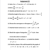

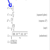

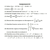

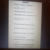

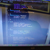

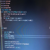

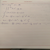

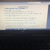

In [ ]:
# Create a hover widget that displays the image preview
def on_hover(change):
    filename = change['new']
    if filename in [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list)]:
        image = image_dict[filename[filename.find('_')+1:]]['image']
        display(image.resize((50,50)))

# Create a list widget that displays the filenames
list_widget = ipywidgets.Select(
    options= [f'{i}_{filename_and_dict[0]}' for i, filename_and_dict in enumerate(image_list)],
    description='Filenames:',
    layout=ipywidgets.Layout(width='50%')
)

# Link the hover widget to the list widget
list_widget.observe(on_hover, names='value')

# Create a VBox container for the widgets
container = ipywidgets.VBox([list_widget])

# Display the container
display(container)

In [ ]:
# debugging:
# by manually checking the image's displays, we see that most of the images until index 936 are screenshots, so we'll move these images
for i, filename in enumerate([filename_and_dict[0] for filename_and_dict in image_list]):
    if i == 937:
        break
    src_path = joinPaths('../academicimagestemp/ashraf_delete/', filename)
    dest_path = joinPaths('../academicimagestemp/ash2_dig/', filename)
    shutil.move(src_path, dest_path)